# Welcome to Caustic!

In need of a differentiable strong gravitational lensing simulation package? Look no further! We have all your lensing simulator needs. In this tutorial we will cover the basics of caustic and how to get going making your own lensing configurations. Caustic is easy to use and very powerful, you will get to see some of that power here, but there will be more notebooks which demo specific use cases.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.nn.functional import avg_pool2d
import matplotlib.pyplot as plt
from ipywidgets import interact
from astropy.io import fits
import numpy as np

import caustic
from caustic.utils import get_meshgrid
from caustic.cosmology import FlatLambdaCDM
from caustic.lenses import SIE, NFW
from caustic.sources import Sersic, Pixelated
from caustic import Parametrized
from caustic import Simulator

In [2]:
n_pix = 100
res = 0.05
upsample_factor = 2
fov = res * n_pix
thx, thy = caustic.get_meshgrid(res/upsample_factor, upsample_factor*n_pix, upsample_factor*n_pix, dtype=torch.float32)
z_l = torch.tensor(0.5, dtype=torch.float32)
z_s = torch.tensor(1.5, dtype=torch.float32)
cosmology = FlatLambdaCDM(name = "cosmo")
cosmology.to(dtype=torch.float32)

FlatLambdaCDM(
    name='cosmo',
    static=[h0, critical_density_0, Om0],
    dynamic=[],
    x keys=[]
)

## Simulating an SIE lens

Here we will demo the very basics of lensing with a classic `SIE` lens model. We will see what it takes to make an `SIE` model, lens a backgorund `Sersic` source, and sample some examples in a simulator. Caustic simulators can generalize to very complex scenarios. In these cases there can be a lot of parameters moving through the simulator, and the order/number of parameters may change depending on what lens or source is being used. To streamline this process, caustic impliments a class called `Parametrized` which has some knowledge of the parameters moving through it, this way it can keep track of everything for you. For this to work, you must put the parameters into a `Packed` object which it can recognize, each sub function can then unpack the parameters it needs. Below we will show some examples of what this looks like.

In [7]:
# demo simulator with sersic source, SIE lens. then sample some examples. demo the model graph

class Simple_Sim(Simulator):
    def __init__(
        self,
        lens,
        src,
        z_s=None,
        name: str = "sim",
    ):
        super().__init__(name) # need this so `Parametrized` can do its magic
        
        # These are the lens and source objects to keep track of
        self.lens = lens
        self.src = src
        
        # Here we can add a parameter to the simulator, in this case it is `z_s` which we will need later
        self.add_param("z_s", z_s)

    def forward(self, params):# define the forward model
        # Here the simulator unpacks the parameter it needs
        z_s = self.unpack(params)

        # Note this is very similar to before, except the packed up `x` is all the raytrace function needs to work
        bx, by = self.lens.raytrace(thx, thy, z_s, params)
        mu_fine = self.src.brightness(bx, by, params)
        
        # We return the sampled brightness at each pixel location
        return avg_pool2d(mu_fine.squeeze()[None, None], upsample_factor)[0, 0]

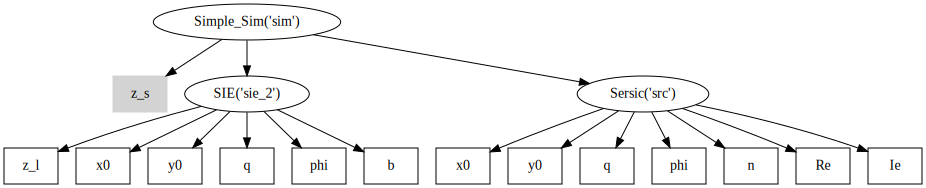

In [8]:
sie = caustic.lenses.SIE(cosmology, name = "sie")
src = caustic.sources.Sersic(name = "src")

sim = Simple_Sim(sie, src, torch.tensor(0.8))

sim.get_graph(True, True)

In [9]:
print(sim)
print(sie)

Simple_Sim(
    name='sim',
    static=[z_s],
    dynamic=[],
    x keys=[('sie_2': ['z_l', 'x0', 'y0', 'q', 'phi', 'b']), ('src': ['x0', 'y0', 'q', 'phi', 'n', 'Re', 'Ie'])]
)
SIE(
    name='sie_2',
    static=[],
    dynamic=[z_l, x0, y0, q, phi, b],
    x keys=[('sie_2': ['z_l', 'x0', 'y0', 'q', 'phi', 'b'])]
)


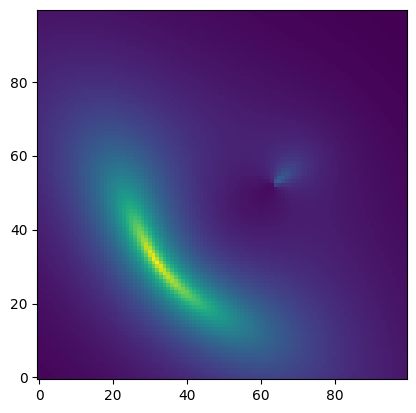

In [10]:
# Reading the x_keys above we can input the parameters that we would like the simulator to evaluate
x = torch.tensor([
    z_l.item(), # sie z_l
    0.7,     # sie x0
    0.13,    # sie y0
    0.4,     # sie q
    np.pi/5, # sie phi
    1.,      # sie b
    -0.2,     # src x0
    -0.5,      # src y0
    0.5,      # src q
    -np.pi/4, # src phi
    1.5,       # src n
    2.5,      # src Re
    1.,       # src Ie
])
plt.imshow(sim(x), origin="lower")

With this simulator framework we can now swap out whatever lens or source we want and we dont hav to rewrite any code, we can just change the input tensor accordingly. This greatly simplifies the development process.

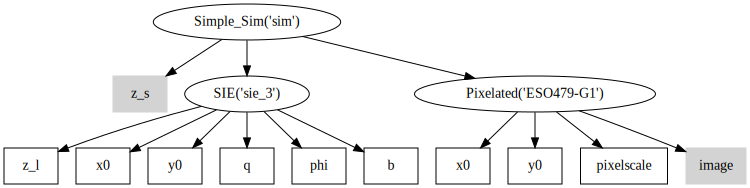

In [11]:
sie = SIE(cosmology,name = "sie")
hdu = fits.open("https://www.legacysurvey.org/viewer/fits-cutout?ra=36.3684&dec=-25.6389&size=250&layer=ls-dr9&pixscale=0.262&bands=r")
image_data = np.array(hdu[0].data, dtype = np.float64)
src = Pixelated(name = "ESO479-G1", image = torch.tensor(image_data, dtype = torch.float32))

sim2 = Simple_Sim(sie, src, torch.tensor(0.8))

sim2.get_graph(True, True)

In [12]:
print(sim2)

Simple_Sim(
    name='sim',
    static=[z_s],
    dynamic=[],
    x keys=[('sie_3': ['z_l', 'x0', 'y0', 'q', 'phi', 'b']), ('ESO479-G1': ['x0', 'y0', 'pixelscale'])]
)


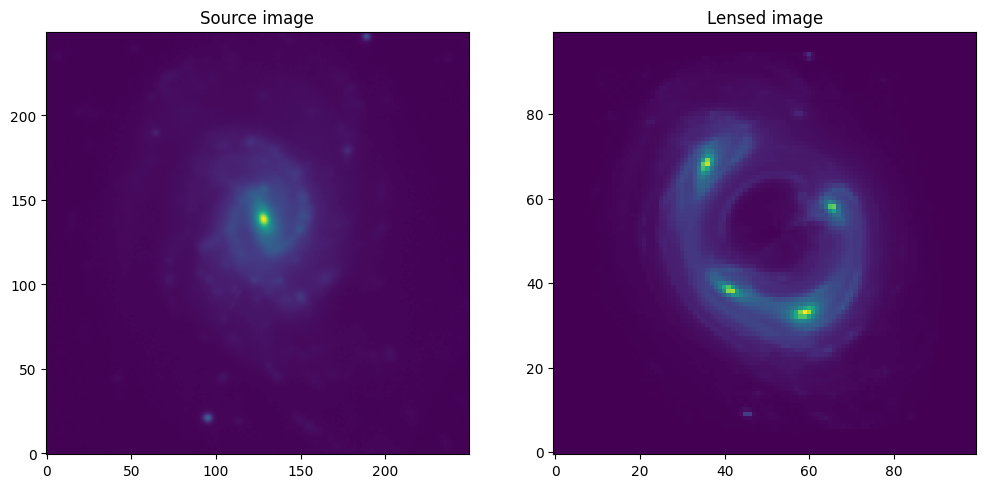

In [18]:
# x can also be a dict
x = torch.tensor([
    z_l.item(), # sie z_l
    0.2,     # sie x0
    0.1,    # sie y0
    0.4,     # sie q
    np.pi/5, # sie phi
    1.,      # sie b
    0.0,     # src x0
    0.0,      # src y0
    0.01,      # src pixelscale
])
fig, axarr = plt.subplots(1, 2, figsize = (12,6))
axarr[0].imshow(image_data, origin = "lower")
axarr[0].set_title("Source image")
axarr[1].imshow(sim2(x), origin="lower")
axarr[1].set_title("Lensed image")
plt.show()

# Setting static/dynamic parameters

So far we have assumed that all parameters for the source and lens are being modelled. However, it is often the case that a parameter can/must be fixed for a given science case. It is very easy to do this in Caustic, simply pass the fixed value when constructing the lens/source objects.

Below we have fixed some parameters in our simulator by providing them when constructing the objects. In the graph they now appear as greyed boxes. In fact we can see now that the cosmology object `FlatLambdaCDM` had fixed parameters all along. This is because there are natural default parameters for such a cosmology. It is possible, of course, to make a different cosmology object which has alternate values, or which leaves some values as free parameters.

In general, to set a parameter as dynamic (must be passed to the simulator) just set it to `None`, to fix a parameter give it a value.

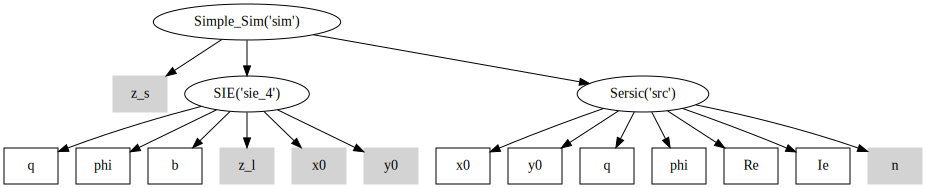

In [14]:
sief = caustic.lenses.SIE(name = "sie", cosmology = cosmology, z_l = torch.tensor(0.5), x0 = torch.tensor(0.), y0 = torch.tensor(0.))
srcf = Sersic(name = "src", n = torch.tensor(2.))

simf = Simple_Sim(sief, srcf, z_s = torch.tensor(0.8))

simf.get_graph(True, True)

In [15]:
# Notice that the "x_keys" is now different. Fixed parameters don't need to be passed since their value is known
print(simf)

Simple_Sim(
    name='sim',
    static=[z_s],
    dynamic=[],
    x keys=[('sie_4': ['q', 'phi', 'b']), ('src': ['x0', 'y0', 'q', 'phi', 'Re', 'Ie'])]
)


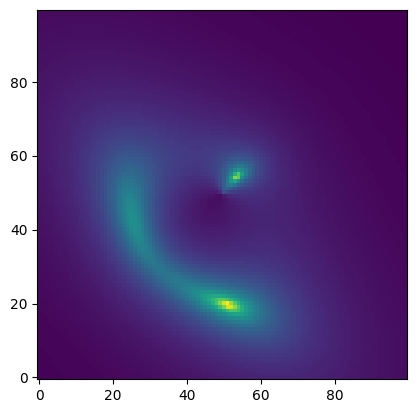

In [16]:
# Reading the x_keys above we can input the parameters that we would like the simulator to evaluate
x = torch.tensor([
    0.4,     # sie q
    np.pi/5, # sie phi
    1.,      # sie b
    -0.2,     # src x0
    -0.5,      # src y0
    0.5,      # src q
    -np.pi/4, # src phi
    2.5,      # src Re
    1.,       # src Ie
])
plt.imshow(simf(x), origin="lower")